# Benchmark missing marker imputation (leave-one-out) for synthetic batches

In [1]:
import cytovi
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib
import os
import seaborn as sns
import matplotlib.pyplot as plt

'param_use_gpu' is not a valid key!


In [2]:
# read data
os.chdir('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/notebooks/')

figure_dir = '../figures/figure3/'

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["savefig.dpi"] = 300

In [ ]:
# read data and subsample
adata = ad.read_h5ad('../data/2024-01-16_model_eval_multi_batch/2024-01-26_nunez_norm.h5ad')
adata = adata[adata.obs['batch']=='1'].copy()
adata = cytovi.pp.subsample(adata, n_obs = 50000)

# create a synthetic batch
batch_labels = np.array([0] * (adata.n_obs // 2) + [1] * (adata.n_obs // 2))
np.random.shuffle(batch_labels)
adata.obs['synth_batch'] = batch_labels
adata.obs['synth_batch'] = adata.obs['synth_batch'].astype('category')

# adata.write('../data/2024-02-20_hyperopt_flow_batch/2024-08-20_nunez_norm_50k_synth_batch.h5ad')

In [3]:
# load imputed data from disk
model_path = '/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/models/imputation_eval/2024-08-20_flow_50k_synth_batch_impute_'
imp_array_stack = np.load(f'{model_path}imputed_array.np.npy') # is protein x samples x cells

In [4]:
# restrict markers
rm_vars = ['FSC-H', 'SSC-H', 'SSC-B-A', 'SSC-B-H', 'CXCR3', 'PD1']
adata = adata[:, [var for var in adata.var_names if var not in rm_vars]].copy()

In [5]:
# Compute cv, std and cv for each marker
mean_sample = np.mean(imp_array_stack, axis=1)
std_sample = np.std(imp_array_stack, axis=1)
var_sample = np.var(imp_array_stack, axis=1)
cv_sample = std_sample / mean_sample

In [6]:
# prepare observed and predicted expr
observed = adata[adata.obs['synth_batch'] == 1, :].X.copy().T # is protein x cells

observed_exp = np.expand_dims(observed, 1)
observed_exp = np.repeat(observed_exp, imp_array_stack.shape[1], axis=1)

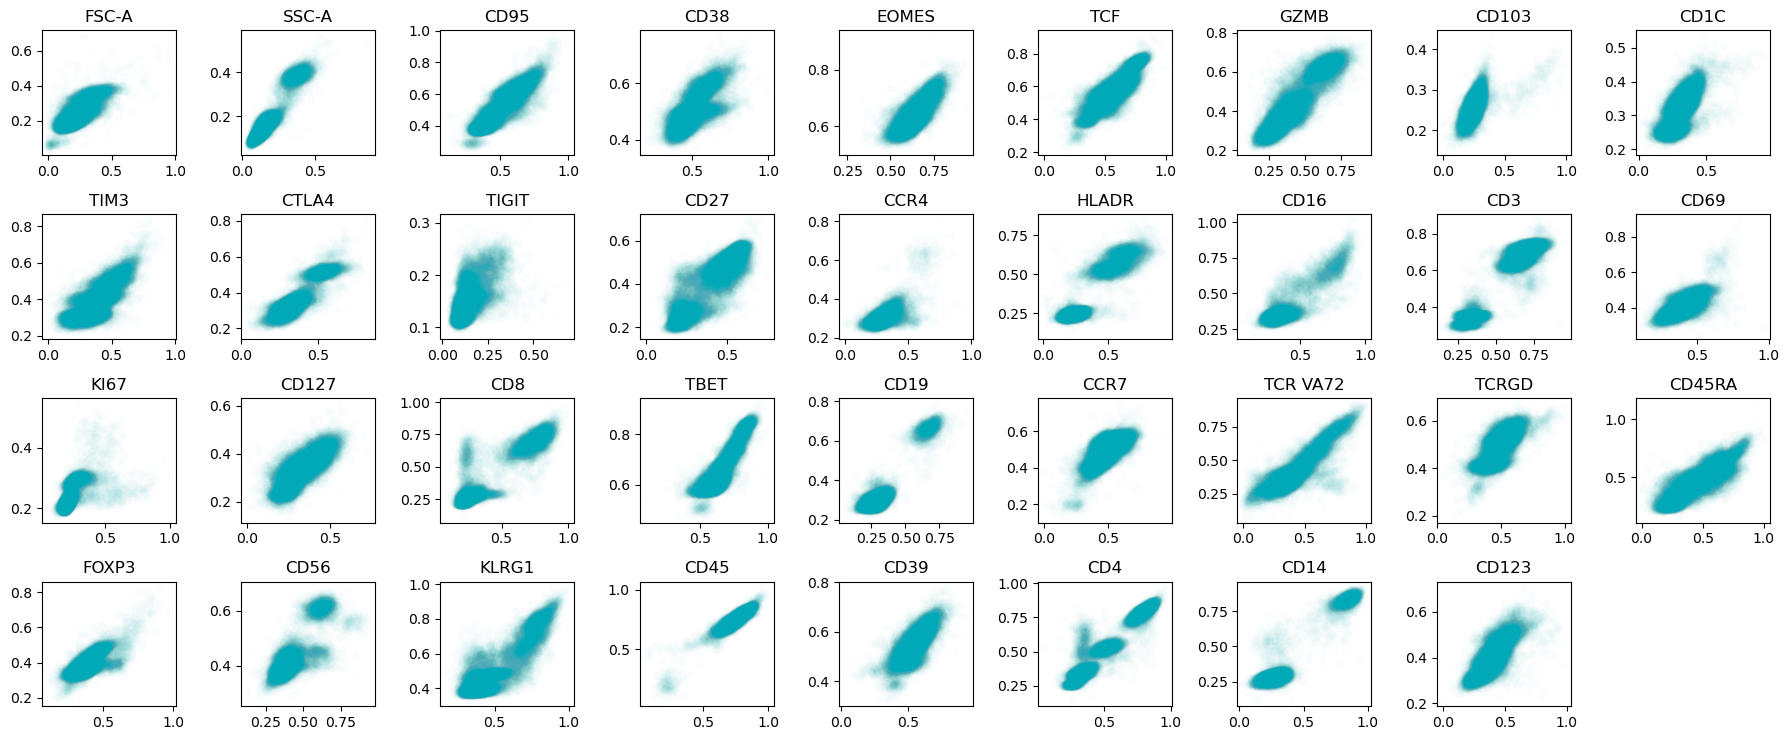

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

ncols = 9
total = adata.n_vars
rows = total // ncols + 1

fig = plt.figure(figsize=(ncols*2, 7.5))
it = 0

for marker in adata.var_names:
    ax = fig.add_subplot(rows, ncols, it+1)
    g = sns.scatterplot(x=observed[it], y=mean_sample[it], ax = ax, edgecolor='none', alpha=0.01, color = '#00A9B8')
    g.set_title(marker)
    g.set_ylabel('')
    g.set_xlabel('')
    it += 1

fig.tight_layout()
fig.savefig(f'{figure_dir}cytovi_imputations_scatter.png')

In [9]:
# export data for cycombine
expr = adata.layers['transformed']
var_names = adata.var_names
obs = adata.obs

expr_df = pd.DataFrame(expr, columns=var_names)

expr_df.to_csv('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-07-05_aurora_imputation_expression.csv')
obs.to_csv('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-07-05_aurora_imputation_obs.csv')

In [10]:
# load cycombine imputations
predicted_cycombine_scaled = pd.read_csv('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-08-21_aurora_imputation_cycombine_imputed.csv', index_col=0)
predicted_cycombine_scaled.columns = var_names

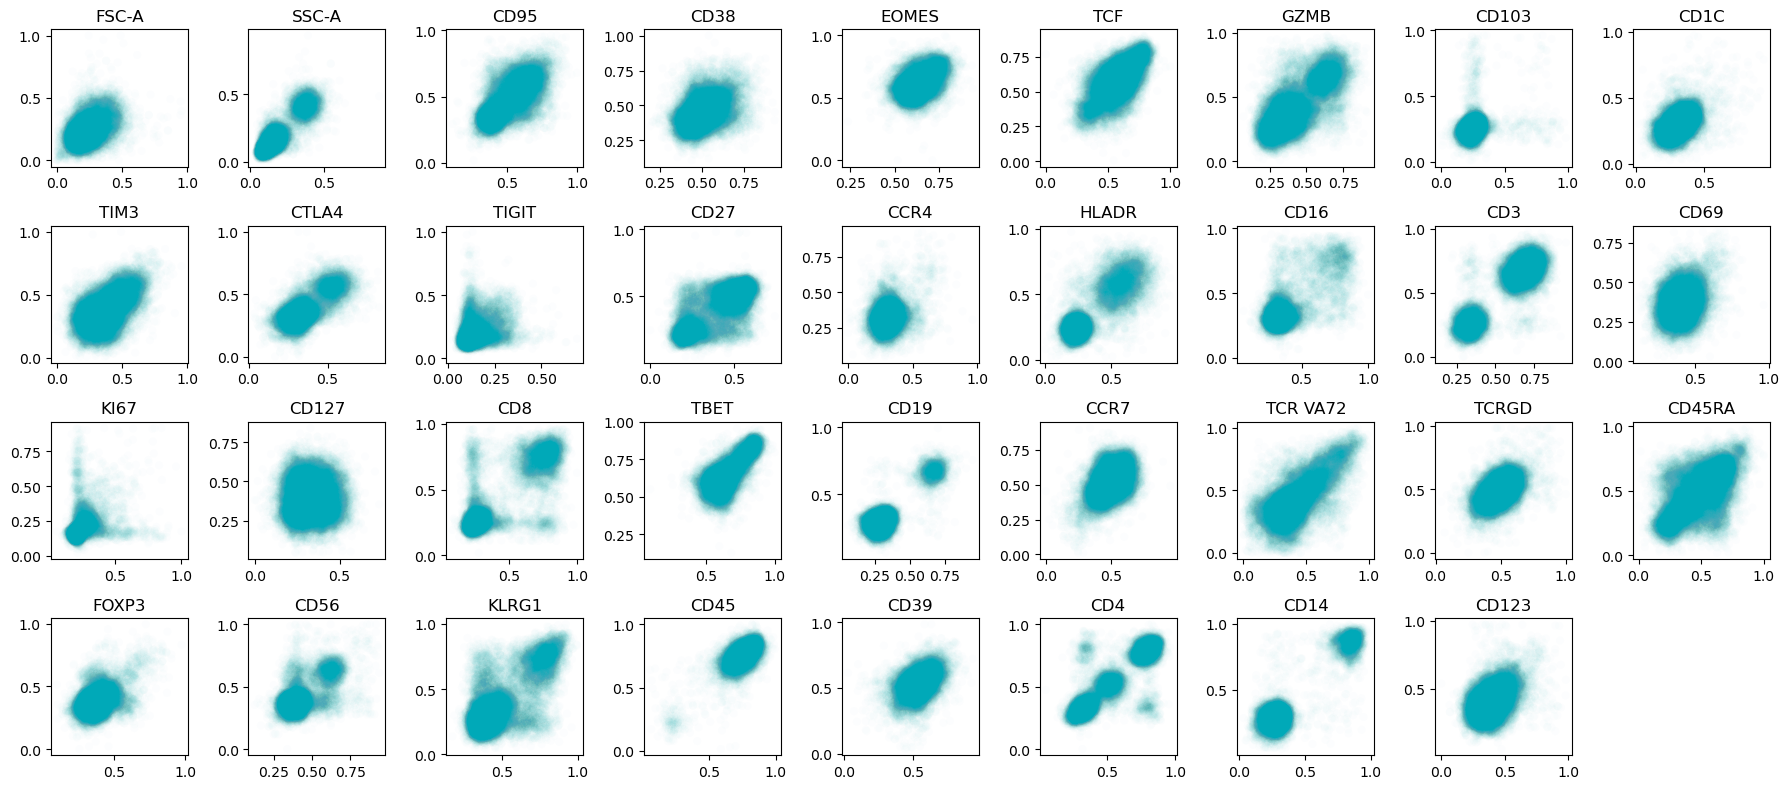

In [11]:
# inspect in scatter plot
ncols = 9
total = adata.n_vars
rows = total // ncols + 1

fig = plt.figure(figsize=(ncols*2, rows*2))
it = 0

for marker in adata.var_names:
    ax = fig.add_subplot(rows, ncols, it+1)
    g = sns.scatterplot(x=observed[it], y=predicted_cycombine_scaled[marker].values, ax = ax, edgecolor='none', alpha=0.01, color = '#00A9B8')
    g.set_title(marker)
    g.set_ylabel('')
    g.set_xlabel('')
    it += 1

fig.tight_layout()

# evaluate relationship between model uncertainty and prediction error

In [12]:
# compute error
pred_error = np.abs(imp_array_stack - observed_exp) # is protein x samples x cells
pred_error_mean = pred_error.mean(axis=1)

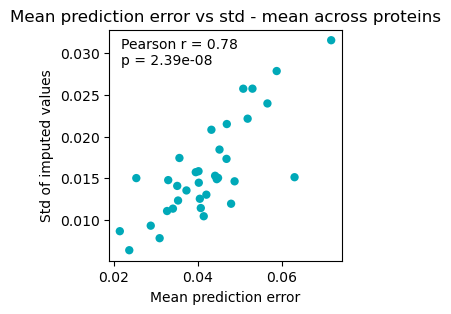

In [14]:
# aggregate on protein axis
from scipy.stats import pearsonr

pred_error_mean_protein = pred_error_mean.mean(axis=1)
std_sample_protein = std_sample.mean(axis=1)

r, p = pearsonr(pred_error_mean_protein, std_sample_protein)

plt.figure(figsize=(3, 3))
sns.scatterplot(x=pred_error_mean_protein, y=std_sample_protein, edgecolor='none', color = '#00A9B8')
plt.title('Mean prediction error vs std - mean across proteins')
plt.xlabel('Mean prediction error')
plt.ylabel('Std of imputed values')

# add text to plot
plt.text(0.05, 0.85, f'Pearson r = {r:.2f}\np = {p:.2e}', transform=plt.gca().transAxes)
plt.savefig(f'{figure_dir}mean_error_vs_std.png')
plt.savefig(f'{figure_dir}mean_error_vs_std.pdf')

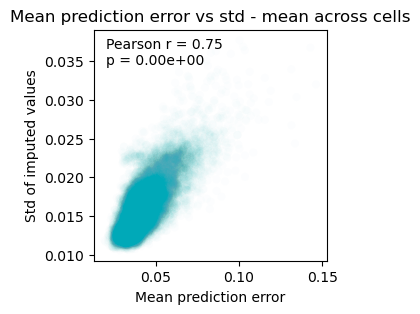

In [15]:
# aggregate on cell axis
pred_error_mean_cell = pred_error_mean.mean(axis=0)
std_sample_cell = std_sample.mean(axis=0)

r, p = pearsonr(pred_error_mean_cell, std_sample_cell)

plt.figure(figsize=(3, 3))
sns.scatterplot(x=pred_error_mean_cell, y=std_sample_cell, edgecolor='none', alpha = 0.01, color = '#00A9B8')
plt.title('Mean prediction error vs std - mean across cells')
plt.xlabel('Mean prediction error')
plt.ylabel('Std of imputed values')

# add text to plot
plt.text(0.05, 0.85, f'Pearson r = {r:.2f}\np = {p:.2e}', transform=plt.gca().transAxes)
plt.savefig(f'{figure_dir}mean_error_vs_std_cells.png')
plt.savefig(f'{figure_dir}mean_error_vs_std_cells.pdf')

# knn imputation as baseline method

In [ ]:
from sklearn.impute import KNNImputer

knn_imputation_dict = {}

for marker in adata.var_names:
    print(f'Processing {marker} now.')
    # mask marker
    adata_masked = cytovi.pp.mask_markers(adata, markers = marker, batch_key = 'synth_batch', nan_layer_registration = False, masked_batch=1)

    # build neighbor graph
    imputer = KNNImputer(n_neighbors = 10)
    adata_masked.layers['scaled'] = imputer.fit_transform(adata_masked.layers['scaled'])
    knn_imputation_dict[marker] = adata_masked[adata_masked.obs['synth_batch'] == 1, marker].layers['scaled'].copy().reshape(-1)


knn_imputation_df = pd.DataFrame.from_dict(knn_imputation_dict)

In [84]:
# # save on disk
# knn_imputation_df.to_csv('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-08-02_aurora_imputation_KNN_imputed.csv')

In [16]:
# load again
knn_imputation_df = pd.read_csv('/home/labs/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-08-02_aurora_imputation_KNN_imputed.csv', index_col = 0)

In [18]:
# generate dfs
predicted = pd.DataFrame(mean_sample.T, columns=adata.var_names)
observed_df = pd.DataFrame(observed.T, columns=adata.var_names)

In [19]:
# compute summary stats
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import pearsonr, spearmanr

summary_dict = {'CytoVI': {}, 'Cycombine': {}, 'KNN': {}}

for marker in adata.var_names:
    # CytoVI
    observed_marker = observed_df[marker].values
    predicted_marker = predicted[marker].values

    mae_metric = mae(observed_marker, predicted_marker)
    pearsonr_metric = pearsonr(observed_marker, predicted_marker)
    spearmanr_metric = spearmanr(observed_marker, predicted_marker)

    summary_dict['CytoVI'][marker] = {
        'mae': mae_metric,
        'pearsonr': pearsonr_metric[0],
        'spearmanr': spearmanr_metric[0]
    }

    # KNN
    predicted_marker = knn_imputation_df[marker].values

    mae_metric = mae(observed_marker, predicted_marker)
    pearsonr_metric = pearsonr(observed_marker, predicted_marker)
    spearmanr_metric = spearmanr(observed_marker, predicted_marker)

    summary_dict['KNN'][marker] = {
        'mae': mae_metric,
        'pearsonr': pearsonr_metric[0],
        'spearmanr': spearmanr_metric[0]
    }

    # cyCombine
    predicted_marker = predicted_cycombine_scaled[marker].values

    # handle nans: note if uncertain cycombine does not return values but nans
    observed_marker = observed_marker[~np.isnan(predicted_marker)]
    predicted_marker = predicted_marker[~np.isnan(predicted_marker)]


    mae_metric = mae(observed_marker, predicted_marker)
    pearsonr_metric = pearsonr(observed_marker, predicted_marker)
    spearmanr_metric = spearmanr(observed_marker, predicted_marker)

    summary_dict['Cycombine'][marker] = {
        'mae': mae_metric,
        'pearsonr': pearsonr_metric[0],
        'spearmanr': spearmanr_metric[0]
    }


summary_df = pd.DataFrame.from_dict(summary_dict)

In [20]:
summary_dict['CytoVI'] = pd.DataFrame(summary_dict['CytoVI'])
summary_dict['CytoVI'] = summary_dict['CytoVI'].reset_index().melt(id_vars='index', var_name = 'marker')
summary_dict['CytoVI']['method'] = 'CytoVI'

summary_dict['KNN'] = pd.DataFrame(summary_dict['KNN'])
summary_dict['KNN'] = summary_dict['KNN'].reset_index().melt(id_vars='index', var_name = 'marker')
summary_dict['KNN']['method'] = 'KNN'

summary_dict['Cycombine'] = pd.DataFrame(summary_dict['Cycombine'])
summary_dict['Cycombine'] = summary_dict['Cycombine'].reset_index().melt(id_vars='index', var_name = 'marker')
summary_dict['Cycombine']['method'] = 'Cycombine'

summary_df = pd.concat([summary_dict['CytoVI'], summary_dict['Cycombine'], summary_dict['KNN']])
summary_df

,index,marker,value,method
0,mae,FSC-A,0.042826,CytoVI
1,pearsonr,FSC-A,0.757859,CytoVI
2,spearmanr,FSC-A,0.729137,CytoVI
3,mae,SSC-A,0.020157,CytoVI
4,pearsonr,SSC-A,0.954120,CytoVI
...,...,...,...,...
100,pearsonr,CD14,0.969922,KNN
101,spearmanr,CD14,0.641616,KNN
102,mae,CD123,0.046283,KNN
103,pearsonr,CD123,0.795484,KNN


In [21]:
# compute prediction errors
pred_error_cytovi = (observed_df - predicted).melt(var_name='marker')
pred_error_cytovi['method'] = 'CytoVI'

pred_error_KNN = (observed_df - knn_imputation_df).melt(var_name='marker')
pred_error_KNN['method'] = 'KNN'

pred_error_cycombine = (observed_df - predicted_cycombine_scaled).melt(var_name='marker')
pred_error_cycombine['method'] = 'Cycombine'

pred_error_comb = pd.concat([pred_error_cytovi, pred_error_cycombine, pred_error_KNN])

In [22]:
# reformat order of summary_df
marker_order = [*summary_df[(summary_df['method']=='CytoVI') & (summary_df['index']=='mae')].sort_values('value')['marker']]
summary_df_pivot = summary_df.pivot_table(index='index', columns=['marker', 'method'], values='value')
columns = summary_df_pivot.columns
new_columns = [(marker, method) for marker in marker_order for method in summary_df['method'].unique()]
summary_df_pivot = summary_df_pivot.reindex(columns=new_columns)

summary_df_pivot.update(summary_df_pivot.astype(float))
summary_df_pivot.update(summary_df_pivot.applymap('{:,.2f}'.format))

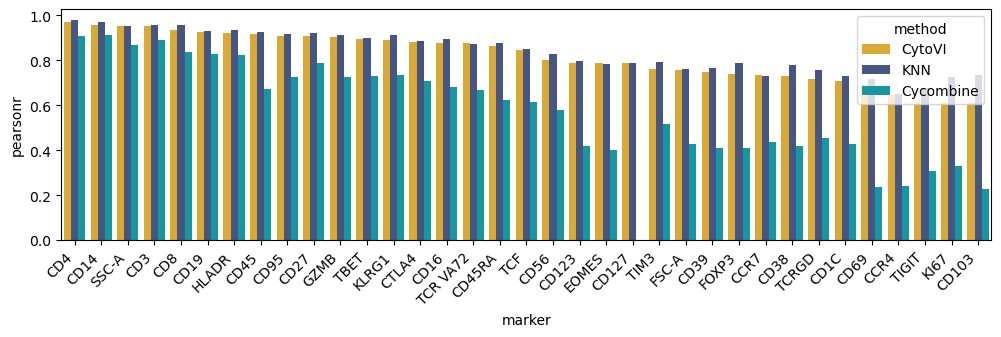

In [24]:
# plot pearson corr for all markers
method_cols = {'CytoVI': '#F6B319','Cycombine': '#00A9B8', 'KNN': '#3A528B'}

summary_df_pearson = summary_df[summary_df['index']=='pearsonr'].drop('index', axis = 1)
order = [*summary_df_pearson[summary_df_pearson['method']=='CytoVI'].sort_values('value', ascending = False)['marker']]

fig, ax = plt.subplots(figsize=(12, 3))
sns.barplot(data = summary_df_pearson, x = 'marker', y = 'value', hue = 'method', order = order, hue_order = ['CytoVI', 'KNN', 'Cycombine'], ax = ax, palette = method_cols)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel('pearsonr')
fig.savefig(f'{figure_dir}barplot_pearsonr_imputation_benchmark.pdf')

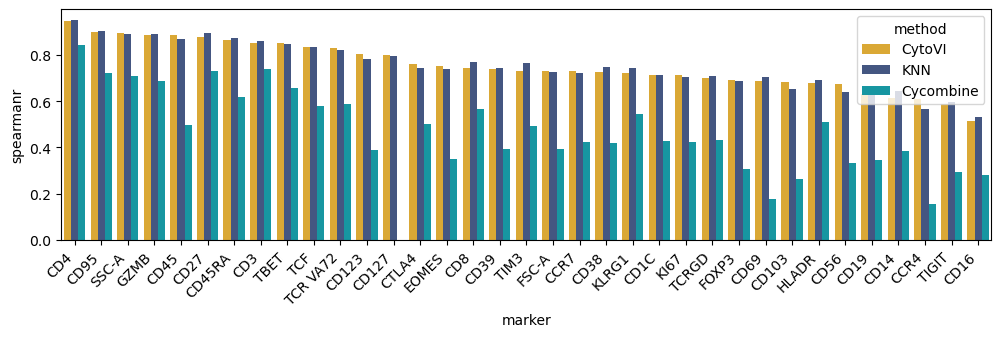

In [25]:
# plot pearson corr for all markers
summary_df_spearman = summary_df[summary_df['index']=='spearmanr'].drop('index', axis = 1)
order = [*summary_df_spearman[summary_df_spearman['method']=='CytoVI'].sort_values('value', ascending = False)['marker']]

fig, ax = plt.subplots(figsize=(12, 3))
sns.barplot(data = summary_df_spearman, x = 'marker', y = 'value', hue = 'method', order = order, hue_order = ['CytoVI', 'KNN', 'Cycombine'], ax = ax, palette = method_cols)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel('spearmanr')
fig.savefig(f'{figure_dir}barplot_spearmanr_imputation_benchmark.pdf')

# Convert to binary classification task

In [26]:
bin_markers = ['FSC-A', 'SSC-A', 'CD95', 'GZMB', 'CD103', 'CD1C', 'CTLA4', 'CD27', 'HLADR', 'CD16', 'CD3', 
                'KI67', 'CD8', 'TBET', 'CD19', 'TCRGD', 'CD45RA', 'FOXP3', 'CD56', 'KLRG1', 'CD45', 'CD4', 'CD14', 'CD123']

In [ ]:
# fit two component GMM
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score 


stats_dict = {'CytoVI': {},'KNN': {}, 'Cycombine': {}}
for marker in bin_markers:
    X = observed_df[marker].values.reshape(-1, 1)
    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(X)
    observed_class = gmm.predict(X)

    # check whether the class is positive
    observed_class = observed_class == np.argmax(gmm.means_)

    X = predicted[marker].values.reshape(-1, 1)
    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(X)
    predicted_class = gmm.predict(X)
    predicted_class = predicted_class == np.argmax(gmm.means_)

    accuracy = accuracy_score(observed_class, predicted_class)
    precision = precision_score(observed_class, predicted_class)
    recall = recall_score(observed_class, predicted_class)
    f1 = f1_score(observed_class, predicted_class)
    auc_class = roc_auc_score(observed_class, predicted_class)
    stats_dict['CytoVI'][marker] = {'accuracy': accuracy, 'precision': precision, 'recall': recall,
                'f1': f1, 'auc_class': auc_class}


    # KNN
    X = knn_imputation_df[marker].values.reshape(-1, 1)
    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(X)
    predicted_class = gmm.predict(X)
    predicted_class = predicted_class == np.argmax(gmm.means_)

    accuracy = accuracy_score(observed_class, predicted_class)
    precision = precision_score(observed_class, predicted_class)
    recall = recall_score(observed_class, predicted_class)
    f1 = f1_score(observed_class, predicted_class)
    auc_class = roc_auc_score(observed_class, predicted_class)
    stats_dict['KNN'][marker] = {'accuracy': accuracy, 'precision': precision, 'recall': recall,
                'f1': f1, 'auc_class': auc_class}

    # repeat for cycombine
    observed_marker = observed_df[marker].values.reshape(-1, 1)
    predicted_marker = predicted_cycombine_scaled[marker].values.reshape(-1, 1)
    observed_marker = observed_marker[~np.isnan(predicted_marker)].reshape(-1, 1)
    predicted_marker = predicted_marker[~np.isnan(predicted_marker)].reshape(-1, 1)

    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(observed_marker)
    observed_class = gmm.predict(observed_marker)
    observed_class = observed_class == np.argmax(gmm.means_)

    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(predicted_marker)
    predicted_class = gmm.predict(predicted_marker)
    predicted_class = predicted_class == np.argmax(gmm.means_)

    accuracy = accuracy_score(observed_class, predicted_class)
    precision = precision_score(observed_class, predicted_class)
    recall = recall_score(observed_class, predicted_class)
    f1 = f1_score(observed_class, predicted_class)
    auc_class = roc_auc_score(observed_class, predicted_class)
    stats_dict['Cycombine'][marker] = {'accuracy': accuracy, 'precision': precision, 'recall': recall,
                'f1': f1, 'auc_class': auc_class}

In [28]:
# reformat stats
stats_dict['CytoVI'] = pd.DataFrame(stats_dict['CytoVI'])
stats_dict['CytoVI'] = stats_dict['CytoVI'].reset_index().melt(id_vars='index', var_name = 'marker')
stats_dict['CytoVI']['method'] = 'CytoVI'

stats_dict['KNN'] = pd.DataFrame(stats_dict['KNN'])
stats_dict['KNN'] = stats_dict['KNN'].reset_index().melt(id_vars='index', var_name = 'marker')
stats_dict['KNN']['method'] = 'KNN'

stats_dict['Cycombine'] = pd.DataFrame(stats_dict['Cycombine'])
stats_dict['Cycombine'] = stats_dict['Cycombine'].reset_index().melt(id_vars='index', var_name = 'marker')
stats_dict['Cycombine']['method'] = 'Cycombine'

bin_stat_df = pd.concat([stats_dict['CytoVI'], stats_dict['Cycombine'], stats_dict['KNN']])
bin_stat_df

,index,marker,value,method
0,accuracy,FSC-A,0.844240,CytoVI
1,precision,FSC-A,0.557646,CytoVI
2,recall,FSC-A,0.746797,CytoVI
3,f1,FSC-A,0.638507,CytoVI
4,auc_class,FSC-A,0.806519,CytoVI
...,...,...,...,...
115,accuracy,CD123,0.823600,KNN
116,precision,CD123,0.672828,KNN
117,recall,CD123,0.823676,KNN
118,f1,CD123,0.740649,KNN


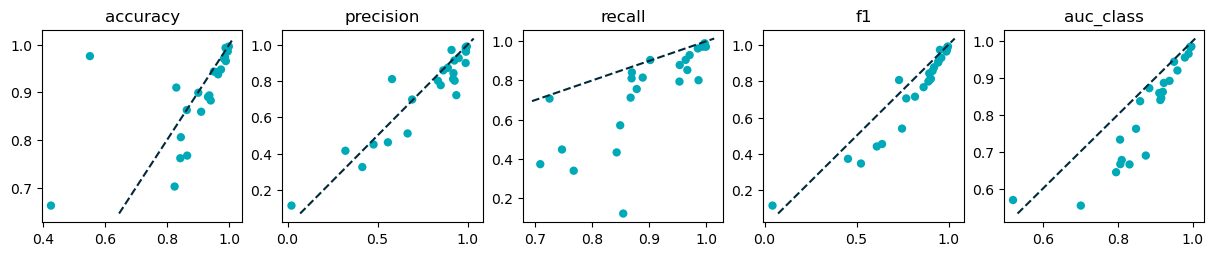

In [29]:
# compare binary predictive power of cycombine to cytovi
it = 0
fig, axes = plt.subplots(1, 5, figsize = (5*3, 2.5))
for metric in bin_stat_df['index'].unique():
    matric_df = bin_stat_df[bin_stat_df['index']==metric].pivot_table(index='marker', columns=['method'], values='value')

    g = sns.scatterplot(x=matric_df['CytoVI'].values, y=matric_df['Cycombine'].values, edgecolor='none', color = '#00A9B8', ax = axes[it])
    g.set_title(metric)
    x0, x1 = g.get_xlim()
    y0, y1 = g.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.plot(lims, lims, color="#00293A", linestyle="dashed", label="x=y")
    g.set_ylabel('')
    g.set_xlabel('')
    it += 1

fig.savefig(f'{figure_dir}scatter_plot_imputation_binary_prediction_cytoVI_cycombine.pdf')

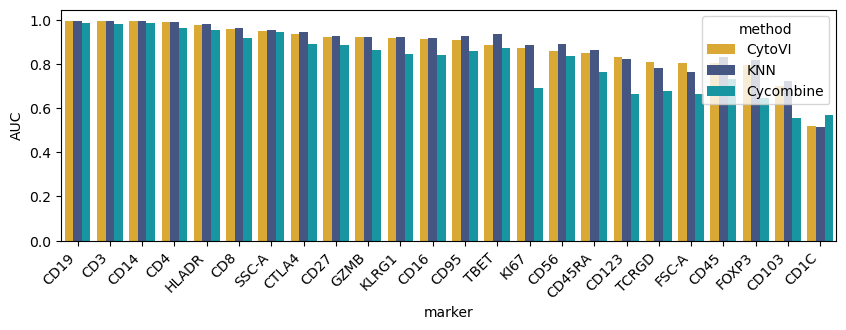

In [31]:
# plot AUCs in bar graphs
auc_long = matric_df.T.reset_index().melt(id_vars = 'method')
order = [*auc_long[auc_long['method']=='CytoVI'].sort_values('value', ascending = False)['marker']]
fig, ax = plt.subplots(figsize=(10, 3))
sns.barplot(data = auc_long, x = 'marker', y = 'value', hue = 'method', order = order, hue_order = ['CytoVI', 'KNN', 'Cycombine'], ax = ax, palette = method_cols)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel('AUC')

fig.savefig(f'{figure_dir}barplot_imputation_binary_prediction_AUC.pdf')